# Autoencoder Manipulation Using UBIRIS

All cells with either a comment on the top saying "WORKING" or with not top comment will work and contribute the output at the end of this notebook. Cells with a "BROKEN" comment will either throw an error or not contribute to the output.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import Model, load_model
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [ ]:
# Load the saved latent vectors and encoder model
filepath = r'/content/drive/MyDrive/ML final project/Trained_models/encoder/encoder_model.h5'
latent_vectors = np.load('/content/drive/MyDrive/ML final project/Trained_models/encoder/latent_vectors.npy')
encoder = load_model(filepath)
#encoder = tf.keras.layers.TFSMLayer('encoder_model', call_endpoint='serving_default')
image_data = np.load('/content/drive/MyDrive/ML final project/Trained_models/encoder/image_data.npy')

In [ ]:
# Define decoder architecture
latent_dim = 64  # Must match encoder's latent_dim
latent_input = tf.keras.Input(shape=(latent_dim,))


# Improved decoder layers with more filters and BatchNormalization
x = Dense(28 * 28 * 128, activation='relu')(latent_input)
x = BatchNormalization()(x)
x = Reshape((28, 28, 128))(x)

x = Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x = BatchNormalization()(x)

x = Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x = BatchNormalization()(x)

x = Conv2DTranspose(32, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x = BatchNormalization()(x)

# Final layer with tanh activation for better color reproduction
decoded_output = Conv2DTranspose(3, (3, 3), activation='tanh', padding='same')(x)

# Create and compile decoder model with a custom loss
decoder = Model(latent_input, decoded_output, name="decoder")
decoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    loss='mse'  # Mean squared error for better image quality
)

# Train the decoder with more epochs and a smaller batch size
print("Training decoder...")
decoder.fit(
    latent_vectors,
    image_data,
    epochs=50,  # Increased epochs
    batch_size=32,  # Smaller batch size
    shuffle=True,
    validation_split=0.1
)


# Save the trained decoder
decoder.save('/content/drive/MyDrive/ML final project/Trained_models/decoder/decoder_model.h5')


Training decoder...
Epoch 1/50
 62/313 ━━━━━━━━━━━━━━━━━━━━ 4:06 982ms/step - loss: 0.3493

KeyboardInterrupt: 

In [ ]:
# WORKING
# Function to reconstruct images from latent vectors
def reconstruct_images(latent_vectors, num_images=5):
    reconstructed = decoder.predict(latent_vectors[:num_images])
    reconstructed = np.clip(reconstructed, 0, 1)

    # Display original vs reconstructed images
    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        # Original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(image_data[i])
        plt.axis('off')
        if i == 0:
            plt.title('Original')

        # Reconstructed image
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(reconstructed[i])
        plt.axis('off')
        if i == 0:
            plt.title('Reconstructed')

    plt.tight_layout()
    plt.show()

# Function to interpolate between two images
def interpolate_images(latent_vector1, latent_vector2, num_steps=10):
    alphas = np.linspace(0, 1, num_steps)
    interpolated_vectors = []

    for alpha in alphas:
        interpolated_vector = (1 - alpha) * latent_vector1 + alpha * latent_vector2
        interpolated_vectors.append(interpolated_vector)

    interpolated_vectors = np.array(interpolated_vectors)
    interpolated_images = decoder.predict(interpolated_vectors)

    # Display interpolation results
    plt.figure(figsize=(15, 3))
    for i in range(num_steps):
        plt.subplot(1, num_steps, i + 1)
        plt.imshow(interpolated_images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
print(os.path.exists(filepath))

In [ ]:

# WORKING
def get_color_examples(labels_df, latent_vectors, color_name, n=1):
    """Get latent vectors for eyes of a specific color"""
    color_indices = labels_df[labels_df['label'] == color_name].index[:n]
    return latent_vectors[color_indices]

def interpolate_color_sequence(decoder, latent_vectors, labels_df, colors=['brown', 'blue', 'hazel', 'green', 'gray'], steps_between=10):
    """Create a sequence of interpolations between different eye colors"""
    # Get one example for each color
    color_vectors = [get_color_examples(labels_df, latent_vectors, color, 1)[0] for color in colors]

    plt.figure(figsize=(20, 4 * (len(colors)-1)))
    current_plot = 1

    # Interpolate between consecutive colors
    for i in range(len(colors)-1):
        print(f"Interpolating from {colors[i]} to {colors[i+1]}...")

        # Create interpolation
        alphas = np.linspace(0, 1, steps_between)
        interpolated_vectors = []

        for alpha in alphas:
            interpolated_vector = (1 - alpha) * color_vectors[i] + alpha * color_vectors[i+1]
            interpolated_vectors.append(interpolated_vector)

        interpolated_vectors = np.array(interpolated_vectors)
        interpolated_images = decoder.predict(interpolated_vectors)
        interpolated_images = np.clip(interpolated_images, 0, 1)


        # Plot this interpolation sequence
        plt.subplot(len(colors)-1, 1, current_plot)
        for j in range(steps_between):
            plt.subplot(len(colors)-1, steps_between, (current_plot-1)*steps_between + j + 1)
            plt.imshow(interpolated_images[j])
            plt.axis('off')
            if j == 0:
                plt.title(f'{colors[i]}', loc='left')
            elif j == steps_between-1:
                plt.title(f'{colors[i+1]}', loc='right')

        current_plot += 1

    plt.tight_layout()
    plt.show()





Reconstructing sample images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


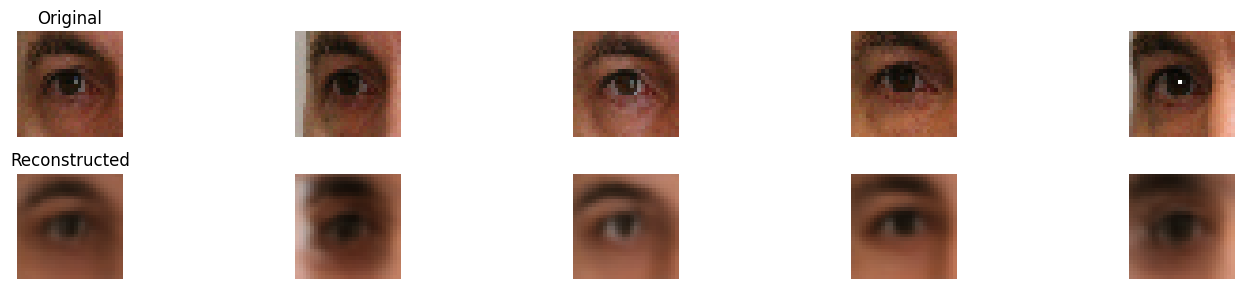


Interpolating between two random images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


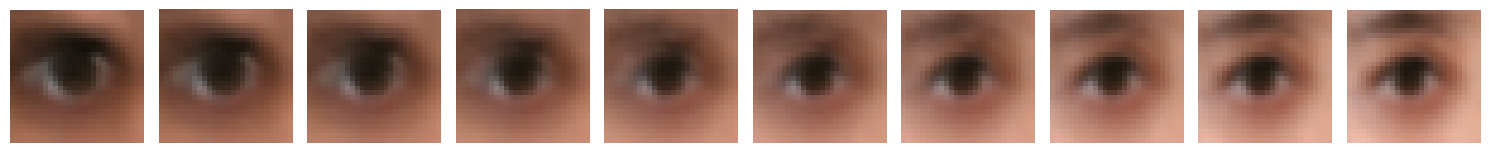


Interpolating between different eye colors...
Interpolating from brown to blue...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Interpolating from blue to hazel...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Interpolating from hazel to green...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Interpolating from green to gray...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


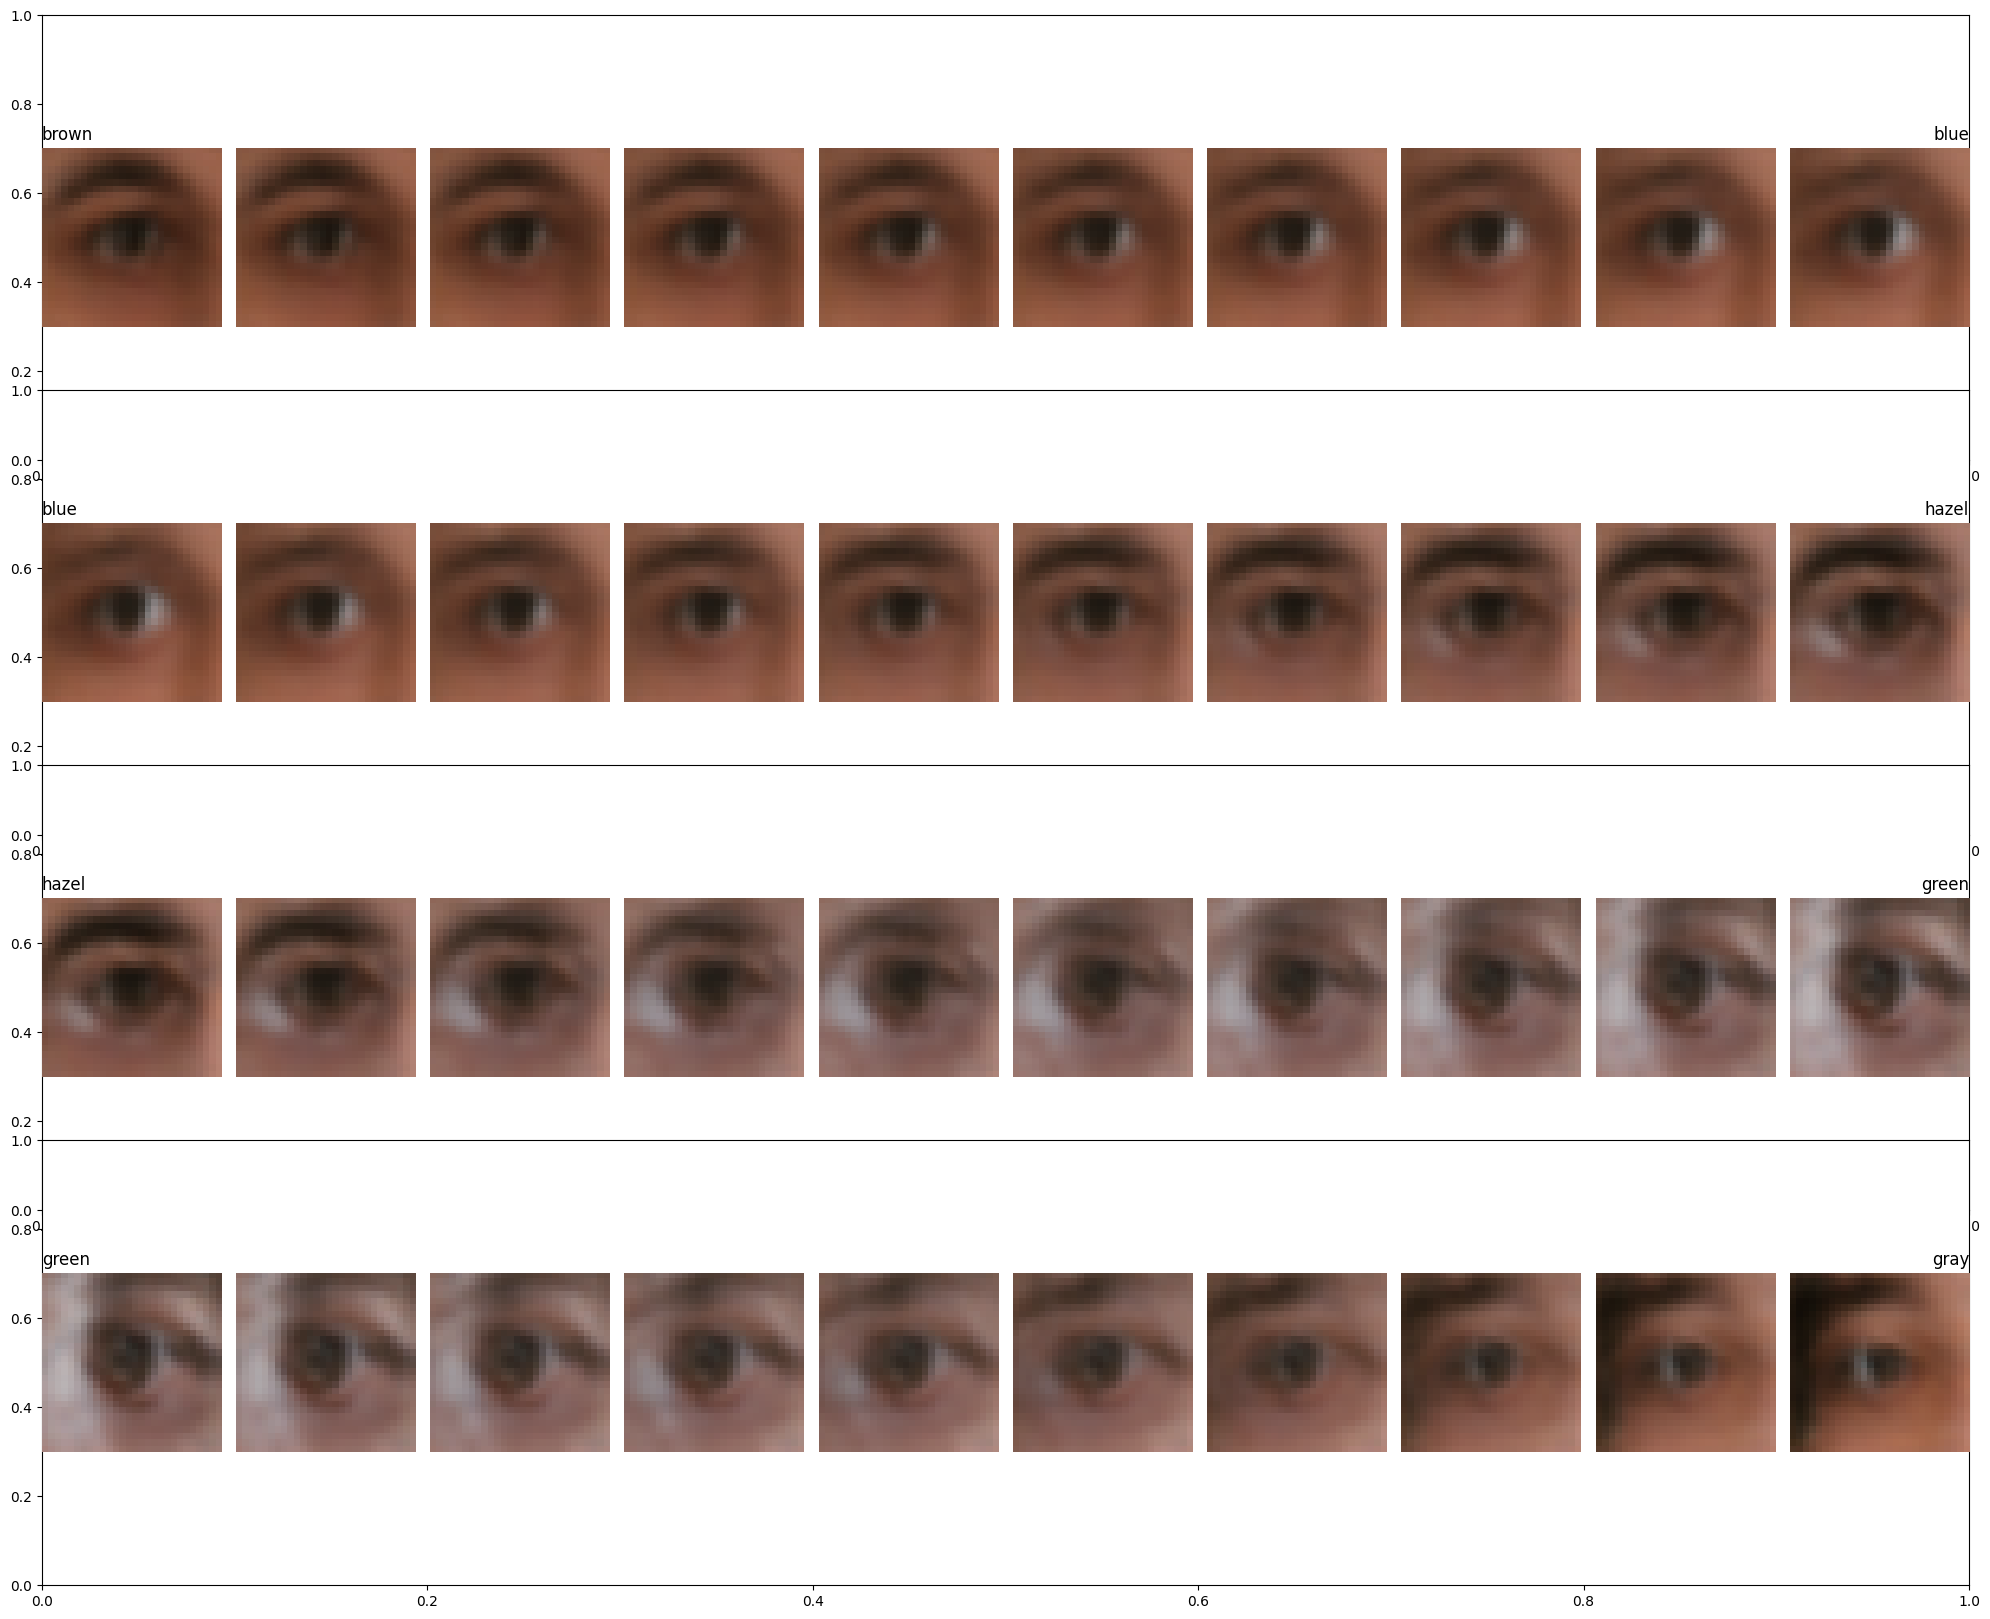

In [ ]:
# WORKING
if __name__ == "__main__":
    # Example usage
    print("Reconstructing sample images...")
    reconstruct_images(latent_vectors)

    print("\nInterpolating between two random images...")
    idx1, idx2 = np.random.randint(0, len(latent_vectors), 2)
    interpolate_images(latent_vectors[idx1], latent_vectors[idx2])

    # Load the labels
    labels_df = pd.read_csv('/content/drive/MyDrive/ML final project/datasets/iris_labels_full.csv')
    print("\nInterpolating between different eye colors...")
    interpolate_color_sequence(decoder, latent_vectors, labels_df)

This is the result of interpolating the latent vectors representing two images of different classes, then reconstructing this sequence.

In [ ]:
!pip install tensorflow==2.11.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 31.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninst

In [ ]:
!pip install colormath

  Preparing metadata (setup.py) ... done
  Created wheel for colormath: filename=colormath-3.0.0-py3-none-any.whl size=39406 sha256=247836d57ae75c70786096791aaebcadef139d4fbd6740b10a7158c0134faa6d
  Stored in directory: /root/.cache/pip/wheels/ab/b3/4d/c0738759c25a1df01958068f162cf2a9dc3ab1da8b972cfcfc
Successfully built colormath


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from sklearn.cluster import KMeans
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000

# Load the trained decoder and necessary data
filepath = r'/content/drive/MyDrive/ML final project/Trained_models/decoder/decoder_model2.h5'
decoder = load_model(filepath, custom_objects={'Conv2DTranspose': tf.keras.layers.Conv2DTranspose})
latent_vectors = np.load('/content/drive/MyDrive/ML final project/Trained_models/encoder/latent_vectors2.npy')
image_data = np.load('/content/drive/MyDrive/ML final project/Trained_models/encoder/image_data2.npy')


In [ ]:
# WORKING
def reconstruct_images(latent_vectors, num_images=5):
    reconstructed = decoder.predict(latent_vectors[:num_images])
    reconstructed = np.clip(reconstructed, 0, 1)

    plt.figure(figsize=(15, 4))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(image_data[i])
        plt.axis('off')
        if i == 0:
            plt.title('Original')

        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(reconstructed[i])
        plt.axis('off')
        if i == 0:
            plt.title('Reconstructed')

    plt.tight_layout()
    plt.show()

In [ ]:
# WORKING
def get_color_examples(labels_df, latent_vectors, color_name, n=1):
    """Get latent vectors for eyes of a specific color"""
    color_indices = labels_df[labels_df['label'] == color_name].index[:n]
    return latent_vectors[color_indices]

def interpolate_color_sequence(decoder, latent_vectors, labels_df, colors=['brown', 'blue', 'hazel', 'green'], steps_between=10):
    color_vectors = [get_color_examples(labels_df, latent_vectors, color, 1)[0] for color in colors]

    plt.figure(figsize=(20, 4 * (len(colors)-1)))
    current_plot = 1

    for i in range(len(colors)-1):
        print(f"Interpolating from {colors[i]} to {colors[i+1]}...")

        alphas = np.linspace(0, 1, steps_between)
        interpolated_vectors = []

        for alpha in alphas:
            interpolated_vector = (1 - alpha) * color_vectors[i] + alpha * color_vectors[i+1]
            interpolated_vectors.append(interpolated_vector)

        interpolated_vectors = np.array(interpolated_vectors)
        interpolated_images = decoder.predict(interpolated_vectors)
        interpolated_images = np.clip(interpolated_images, 0, 1)

        for j in range(steps_between):
            plt.subplot(len(colors)-1, steps_between, (current_plot-1)*steps_between + j + 1)
            plt.imshow(interpolated_images[j])
            plt.axis('off')
            if j == 0:
                plt.title(f'{colors[i]}', loc='left')
            elif j == steps_between-1:
                plt.title(f'{colors[i+1]}', loc='right')

        current_plot += 1

    plt.tight_layout()
    plt.show()

In [ ]:
import random
# SOMEWHAT WORKING
def randomer_interpolater(decoder, latent_vectors, labels_df, colors=['brown', 'blue', 'hazel', 'green'], steps_between=10):
    """Create a sequence of interpolations between different eye colors using random images"""

    color_vectors = []
    for color in colors:
        # Get indices of images for the current color
        color_indices = labels_df[labels_df['label'] == color].index

        # Randomly select one image from the color indices
        random_index = random.choice(color_indices)
        color_vectors.append(latent_vectors[random_index])

    plt.figure(figsize=(20, 4 * (len(colors)-1)))
    current_plot = 1

    # Interpolate between consecutive colors
    for i in range(len(colors)-1):
        print(f"Interpolating from {colors[i]} to {colors[i+1]}...")

        # Create interpolation
        alphas = np.linspace(0, 1, steps_between)
        interpolated_vectors = []

        for alpha in alphas:
            interpolated_vector = (1 - alpha) * color_vectors[i] + alpha * color_vectors[i+1]
            interpolated_vectors.append(interpolated_vector)

        interpolated_vectors = np.array(interpolated_vectors)
        interpolated_images = decoder.predict(interpolated_vectors)
        interpolated_images = np.clip(interpolated_images, 0, 1)

        # Plot this interpolation sequence
        plt.subplot(len(colors)-1, 1, current_plot)
        for j in range(steps_between):
            plt.subplot(len(colors)-1, steps_between, (current_plot-1)*steps_between + j + 1)
            plt.imshow(interpolated_images[j])
            plt.axis('off')
            if j == 0:
                plt.title(f'{colors[i]}', loc='left')
            elif j == steps_between-1:
                plt.title(f'{colors[i+1]}', loc='right')

        current_plot += 1

    plt.tight_layout()
    plt.show()

In [ ]:
import cv2
# SOMEWHAT WORKING
def find_best_representative_images(image_data, labels_df, colors=['brown', 'blue', 'hazel', 'green']):
    """Finds the best representative image for each eye color class"""

    best_representatives = {}
    for color in colors:
        color_indices = labels_df[labels_df['label'] == color].index
        best_score = -1
        best_index = -1

        for index in color_indices:
            image = image_data[index]

            # Criteria 1: Centered Iris (using Hough Circle Transform)
            # Ensure the image is in the correct format (RGB) before converting to grayscale
            image = image.astype(np.uint8)  # Convert to 8-bit unsigned integer if necessary
            if image.ndim == 3 and image.shape[2] == 3:  # Check if the image is RGB
                gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            else:
                # If the image is not RGB, assume it's already grayscale
                gray = image

            circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=10, maxRadius=30)
            if circles is not None:
                center_score = 1  # Higher score if a circle (iris) is detected
            else:
                center_score = 0

            # Criteria 2: Color Clarity (using standard deviation of color channels)
            color_clarity_score = np.std(image)  # Higher standard deviation indicates more color variation

            # Combine scores (adjust weights as needed)
            score = 0.7 * center_score

            if score > best_score:
                best_score = score
                best_index = index

        best_representatives[color] = image_data[best_index]

    # Display the best representative images
    """
    plt.figure(figsize=(15, 3))
    for i, color in enumerate(colors):
        plt.subplot(1, len(colors), i + 1)
        plt.imshow(best_representatives[color])
        plt.title(color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    """

    return best_representatives

In [ ]:
# BROKEN
def get_dominant_iris_color(image):
    """
    Extracts the dominant color of the iris using Hough Circles and KMeans clustering.
    """
    # Convert to grayscale and apply Hough Circle Transform to detect the iris
    image = image.astype(np.uint8)  # Convert to 8-bit unsigned integer if necessary
    if image.ndim == 3 and image.shape[2] == 3:  # Check if the image is RGB
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        # If the image is not RGB, assume it's already grayscale
        gray = image
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=10, maxRadius=30)

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            # Extract the iris region using the detected circle
            x, y, r = i[0], i[1], i[2]
            iris_region = image[y - r:y + r, x - r:x + r]

            # Reshape the iris region for KMeans clustering
            pixels = iris_region.reshape((-1, 3))

            # Apply KMeans clustering to find the dominant color
            kmeans = KMeans(n_clusters=1)
            kmeans.fit(pixels)
            dominant_color = kmeans.cluster_centers_[0]

            return dominant_color  # Return the dominant color as an RGB array
    print("NO IRIS DETECTED")
    return None  # Return None if no iris is detected

In [ ]:
# BROKEN

def apply_iris_color(base_image, target_image, color_to_apply):
    """
    Applies the extracted iris color to the target image using Hough Circles.
    """
    # Convert to grayscale and apply Hough Circle Transform to detect the iris
    base_image = base_image.astype(np.uint8)  # Convert to 8-bit unsigned integer if necessary
    if base_image.ndim == 3 and base_image.shape[2] == 3:  # Check if the image is RGB
        gray = cv2.cvtColor(base_image, cv2.COLOR_RGB2GRAY)
    else:
        # If the image is not RGB, assume it's already grayscale
        gray = base_image
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=10, maxRadius=30)

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            # Extract the iris region using the detected circle
            x, y, r = i[0], i[1], i[2]
            iris_region = target_image[y - r:y + r, x - r:x + r]

            # Apply the extracted color to the iris region
            iris_region[:, :, :] = color_to_apply.astype(np.uint8)

    return target_image  # Return the modified target image

In [ ]:
# BROKEN

def interpolate_and_apply_color_from_classes(base_image, image_data, labels_df, colors=['brown', 'blue', 'green', 'hazel'], steps_between=10):
    """
    Interpolates between dominant iris colors of different eye color classes and applies them to the base image.
    """
    # Get the best representative images for each color class
    best_representatives = find_best_representative_images(image_data, labels_df, colors)

    # Extract dominant colors from the representative images
    colors_to_apply = [get_dominant_iris_color(best_representatives[color]) for color in colors]

    base_image = best_representatives['brown']

    # Create target images (copies of the base image)
    target_images = [base_image.copy() for _ in range(len(colors))]

    # Call the main interpolation function
    interpolate_and_apply_color(base_image, target_images, colors_to_apply, steps_between)


def interpolate_and_apply_color(base_image, target_images, colors_to_apply, steps_between=10):
    """
    Interpolates between colors and applies them to the target images.
    """
    num_colors = len(colors_to_apply)

    plt.figure(figsize=(20, 4 * num_colors))

    for i, color_to_apply in enumerate(colors_to_apply):
        # Get dominant color of base image
        base_color = get_dominant_iris_color(base_image)

        # Convert colors to Lab color space for better interpolation
        base_color_lab = convert_color(sRGBColor(*base_color / 255.0), LabColor)
        target_color_lab = convert_color(sRGBColor(*color_to_apply / 255.0), LabColor)

        # Interpolate between colors in Lab space
        interpolated_colors_lab = [
            base_color_lab + (target_color_lab - base_color_lab) * alpha
            for alpha in np.linspace(0, 1, steps_between)
        ]

        # Convert back to RGB
        interpolated_colors_rgb = [
            convert_color(color_lab, sRGBColor).get_value_tuple() * 255.0
            for color_lab in interpolated_colors_lab
        ]

        # Apply interpolated colors to target images
        for j, interpolated_color in enumerate(interpolated_colors_rgb):
            modified_image = apply_iris_color(base_image, target_images[i].copy(), interpolated_color)

            # Plot the modified image
            plt.subplot(num_colors, steps_between, i * steps_between + j + 1)
            plt.imshow(modified_image)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

Reconstructing sample images...
1/1 [==============================] - 0s 95ms/step


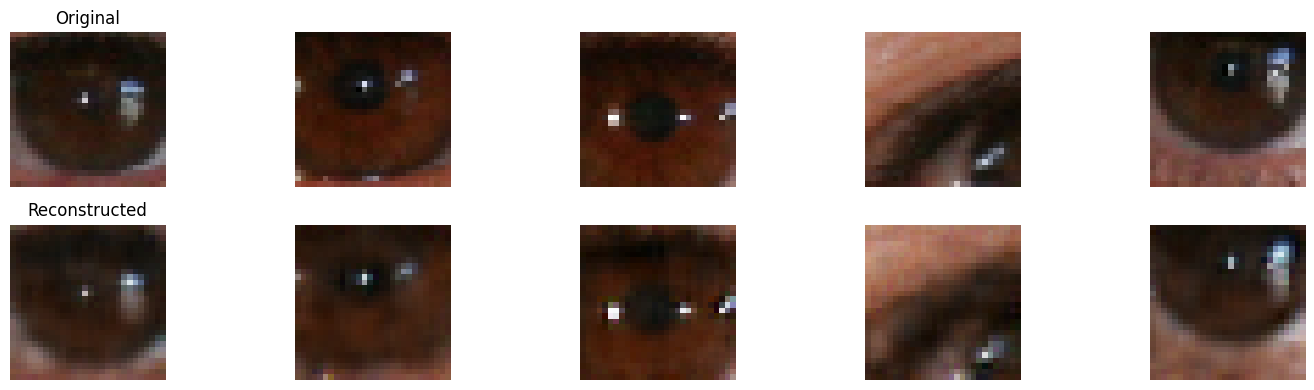


Interpolating between different eye colors...
Interpolating from brown to blue...
1/1 [==============================] - 0s 198ms/step
Interpolating from blue to hazel...
1/1 [==============================] - 0s 215ms/step
Interpolating from hazel to green...
1/1 [==============================] - 0s 209ms/step


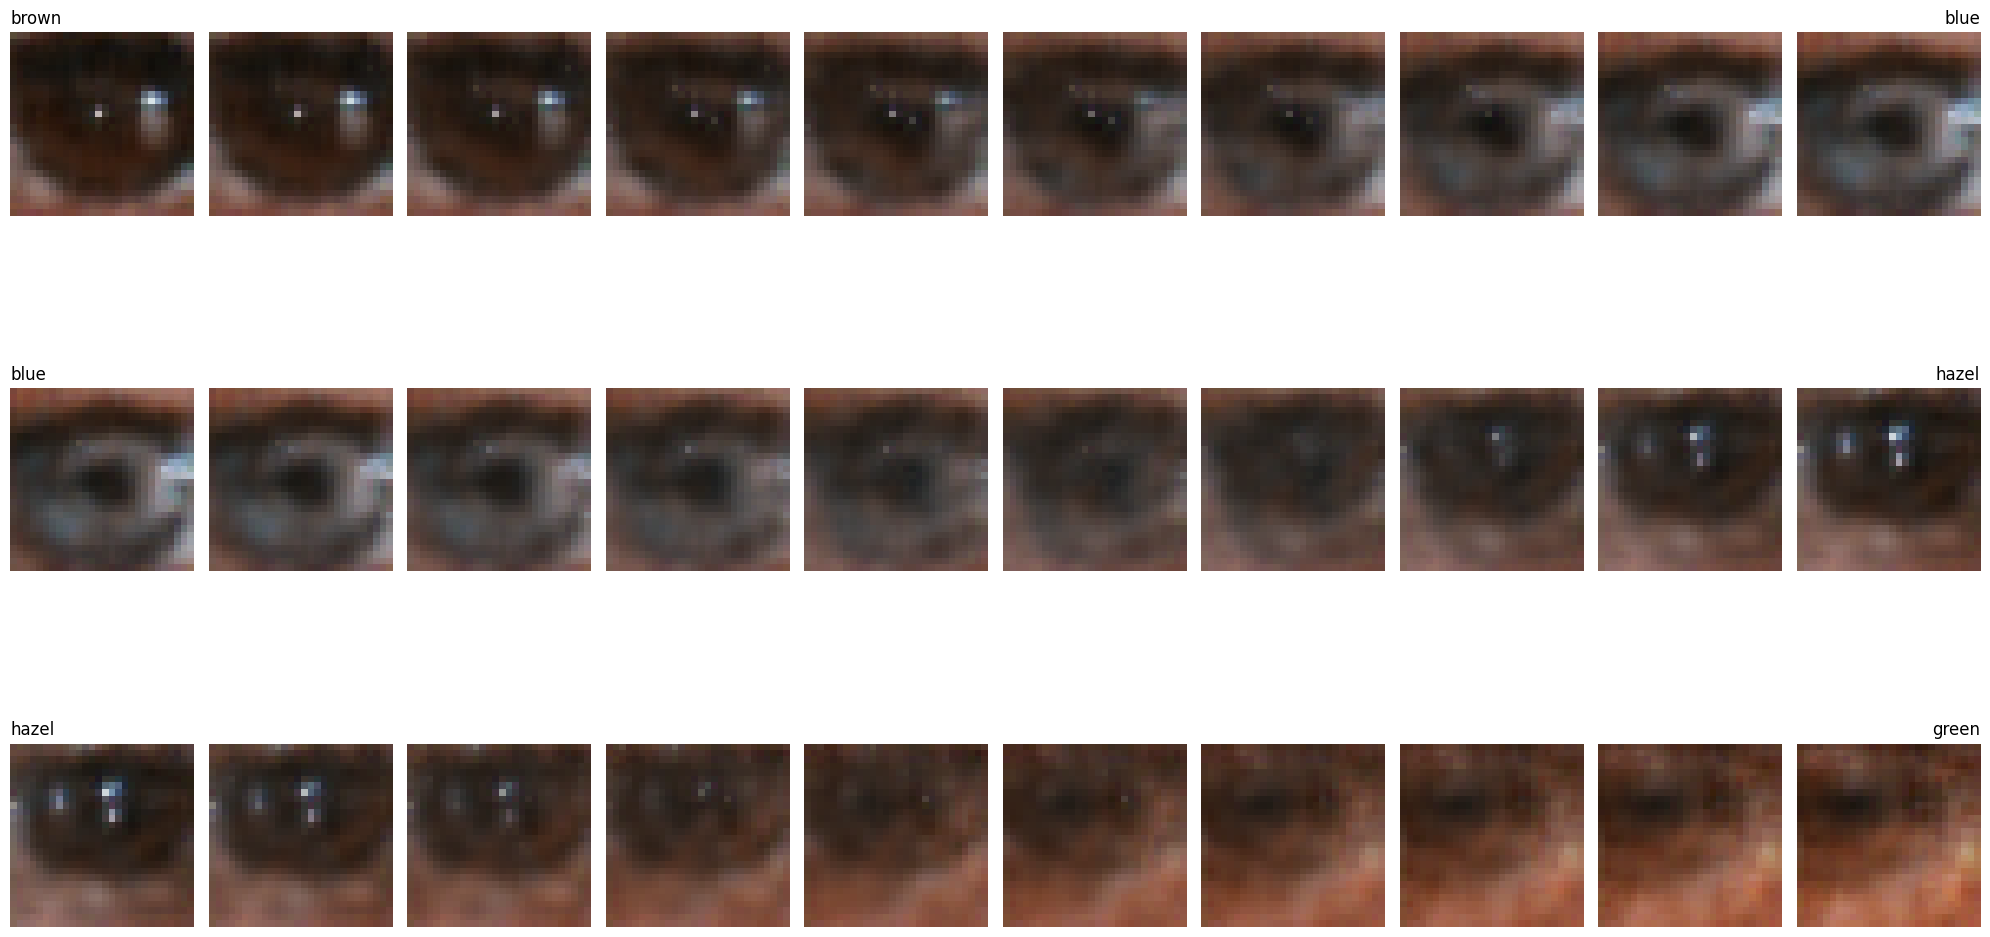


Finding best representative images for each color class...

Experimenting with hue...
NO IRIS DETECTED
NO IRIS DETECTED
NO IRIS DETECTED
NO IRIS DETECTED
NO IRIS DETECTED


TypeError: unsupported operand type(s) for /: 'NoneType' and 'float'

<Figure size 2000x1600 with 0 Axes>

In [ ]:
if __name__ == "__main__":
    # Load the labels
    labels_df = pd.read_csv('/content/drive/MyDrive/ML final project/datasets/filtered_labels.csv')

    print("Reconstructing sample images...")
    reconstruct_images(latent_vectors)

    print("\nInterpolating between different eye colors...")
    interpolate_color_sequence(decoder, latent_vectors, labels_df)

    print("\nFinding best representative images for each color class...")
    find_best_representative_images(image_data, labels_df)

    print("\nExperimenting with hue...")
    interpolate_and_apply_color_from_classes(find_best_representative_images(image_data, labels_df), image_data, labels_df)


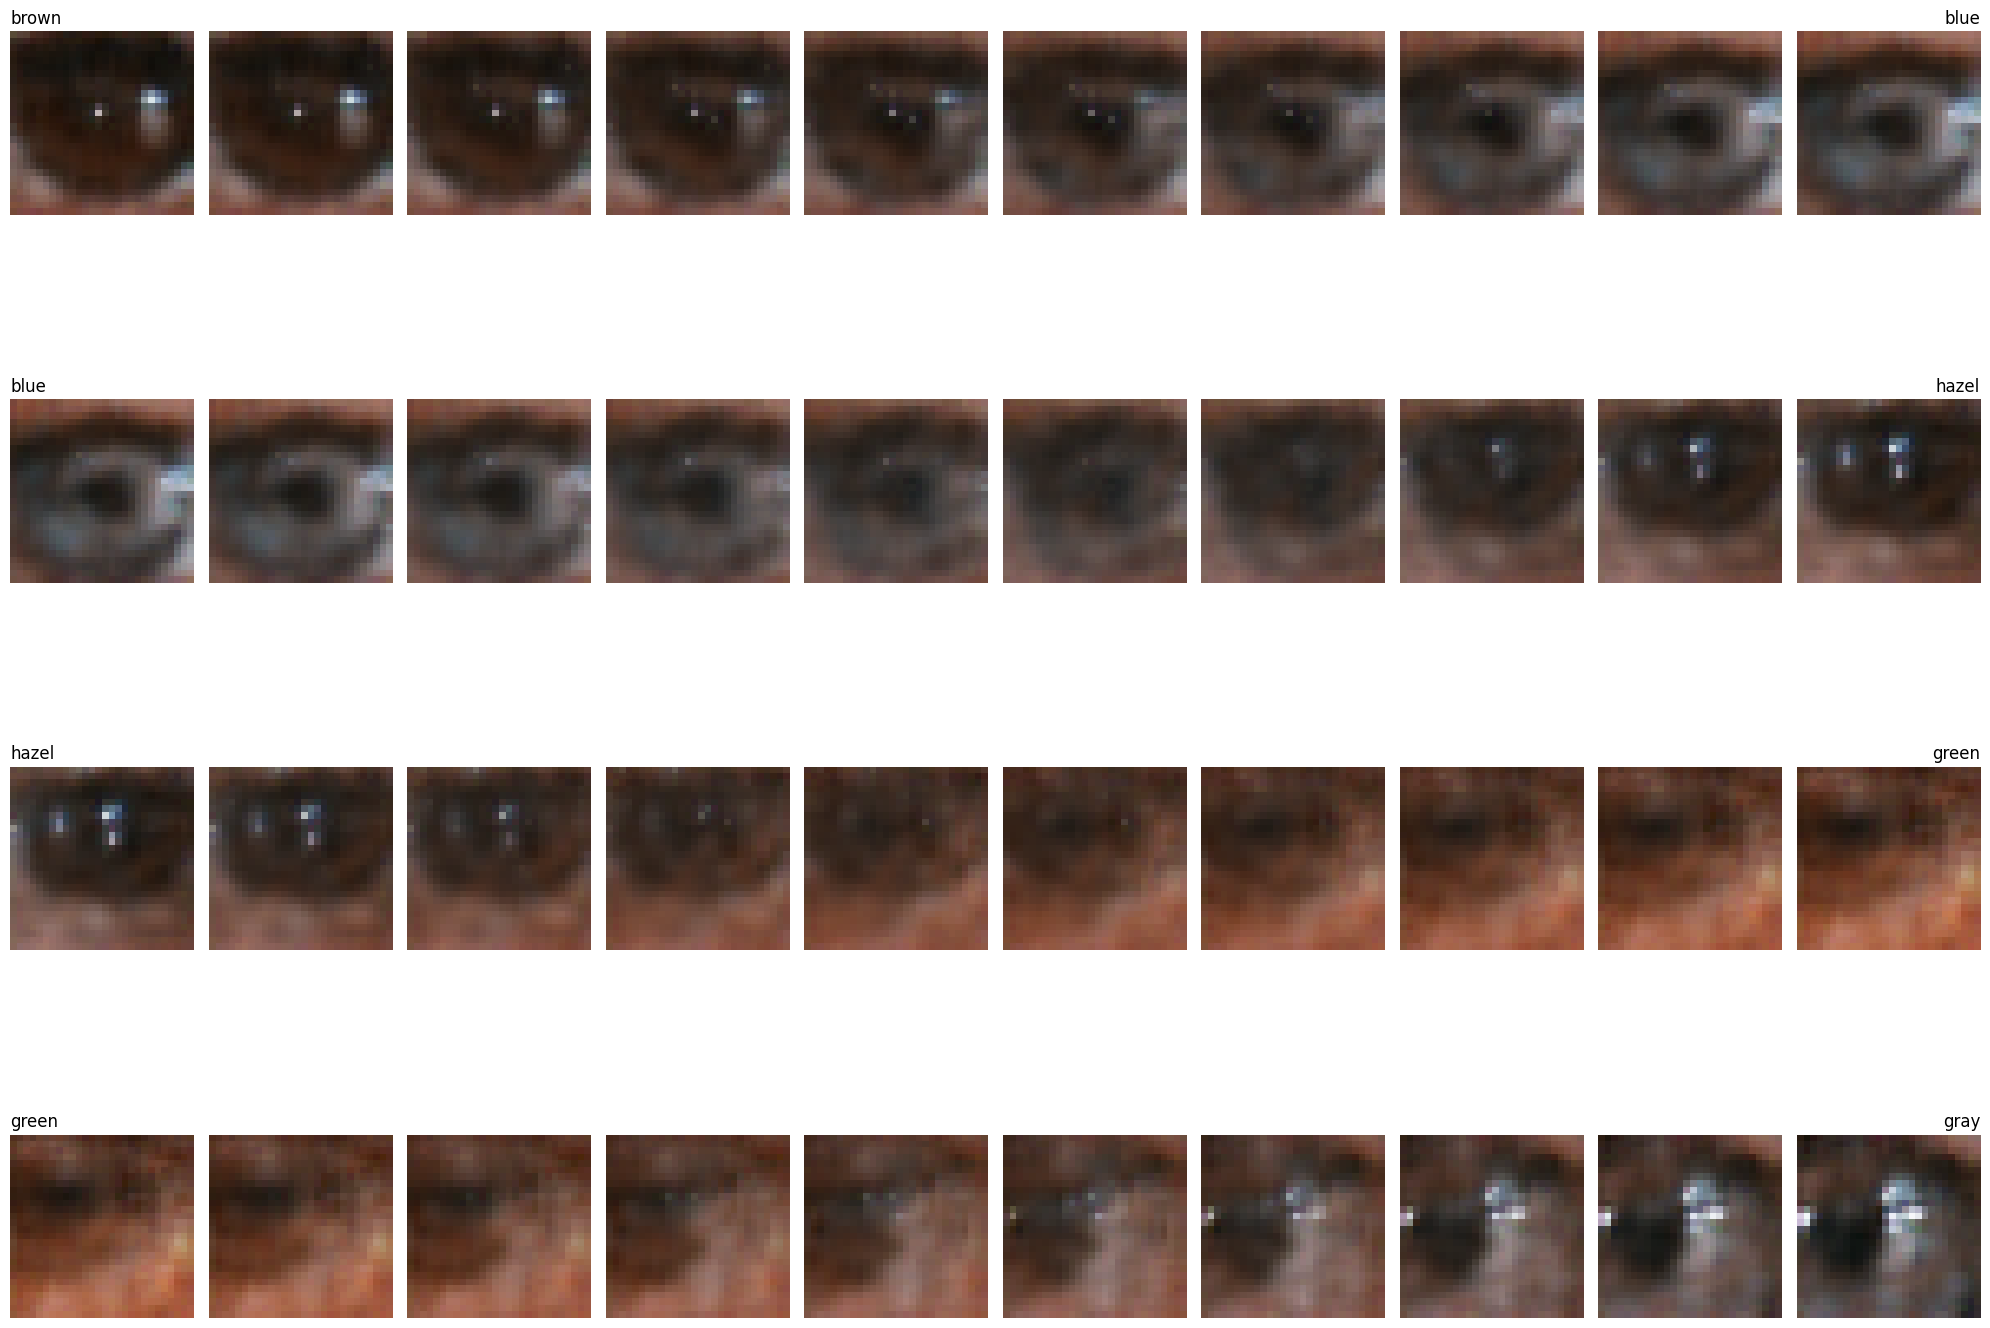